In [0]:
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.applications import NASNetLarge, ResNet50, VGG16
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

import os 
import zipfile

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creating paths for the data and folders to save our weights and models in

In [16]:
root = '/content/drive/My Drive/CAP 4630 Assignments/'
log_path = os.path.join(root, 'logs')
weights_path = os.path.join(root, 'weights', 'weights_temp.h5')
models_path = os.path.join(root, 'models')
os.listdir(root)

['Hw1_Problem1.ipynb',
 'Hw1_Problem2.ipynb',
 'Hw1_Problem3.ipynb',
 'Hw2_Problem1.ipynb',
 'Hw2_Problem2.ipynb',
 'Hw2_Problem3.ipynb',
 'RuTanks7000_v1.zip',
 'logs',
 'RuTanks7000_v1',
 'weights',
 'models',
 'HW3.ipynb']

Extracting files from the zip file, this only needs to be done once

In [0]:
#with zipfile.ZipFile(os.path.join(root, 'RuTanks7000_v1.zip'), 'r') as zip_ref:
 #   zip_ref.extractall(root)

In [18]:
data_path = os.path.join(root, 'RuTanks7000_v1/')
os.listdir(data_path)

['test', 'train']

We remove the civilian car class, leaving us with 6 military vehicle classes. The NAS Large network takes a default image size of 331 x 331. We also set the learning rate, batch size, number of epochs and a few additional parameters for the optimizer and learning rate scheduler.

In [0]:
class_labels = ["Background", "BMP2", "Buk-M1-2", "T14", "T90", "ZSU23"]
num_classes = len(class_labels)
input_height = 331
input_width = 331
batch_size = 64
learning_rate = 0.0001
lr_decay = 0.0001
epochs = 5
patience = 1
factor = 0.5

We will use a small amount of image transformations to reduce overfitting

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(os.path.join(data_path, 'train'),
    target_size=(input_height, input_width),
    batch_size=batch_size,
    shuffle=True,
    classes=class_labels,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(os.path.join(data_path, 'test'),
    target_size=(input_height, input_width),
    batch_size=1,
    shuffle=True,
    classes=class_labels,
    class_mode='categorical')

Found 42000 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


This function will be used to plot the losses and accuracies of each epoch during training

In [0]:
def plot_history(history):
  # Function to plot loss and accuracy history of model
  history_dict = history.history
  epochs_range = range(1, epochs+1)

  # Get loss history
  loss_values = history_dict['loss']
  test_loss_values = history_dict['val_loss']

  # Get accuracy history
  acc_values = history_dict['acc']
  test_acc_values = history_dict['val_acc']

  # plot loss
  plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
  plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # plot accuracy
  plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
  plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
  plt.title('Training and test accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

Finally, we create the model. This uses a pretrained NAS Large networks as the feature extractor. I then add a global average pooling layer to create a vector of features for each image, then feed this into a fully connected layer before being fed to the last fully connected layer, creating length 6 vector of predictions for each image in a batch.

In [0]:
feature_extraction = NASNetLarge(weights='imagenet', include_top=False, input_shape=(input_height, input_width, 3))

model = models.Sequential()
model.add(feature_extraction)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

Here, we freeze all of the layers in the pretrained NAS feature extractor. This means we are simply using what this network learned from ImageNet and applying it to this military dataset. Only the weights in our fully connected layers will be updated.

In [12]:
# freezing the base network
print("trainable layers bevor freezing:", int(len(model.trainable_weights)/2))
feature_extraction.trainable = False
print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
model.summary()

trainable layers bevor freezing: 510
trainable layers after freezing: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1032448   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 85,950,808
Trainable params: 1,033,990
Non-trainable params: 84,916,818
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

callbacks = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_acc', factor=factor, patience=patience, verbose=1)]

We reduce the number of update steps in each epoch in order to train faster. I was unable to keep collab up and running for long enough to train without this change.

In [14]:
# training the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=42000 // (batch_size *  10),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_generator,
    validation_steps=90,
    verbose=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
65/65 [==============================] - 1829s 28s/step - loss: 1.2785 - acc: 0.5358 - val_loss: 1.2736 - val_acc: 0.5111

Epoch 00001: val_acc improved from -inf to 0.51111, saving model to /content/drive/My Drive/CAP 4630 Assignments/weights/weights_temp.h5
Epoch 2/5
65/65 [==============================] - 1721s 26s/step - loss: 0.8288 - acc: 0.7339 - val_loss: 1.2115 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.51111

Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 3/5
65/65 [==============================] - 1742s 27s/step - loss: 0.6684 - acc: 0.7885 - val_loss: 1.1642 - val_acc: 0.5333

Epoch 00003: val_acc improved from 0.51111 to 0.53333, saving model to /content/drive/My Drive/CAP 4630 Assignments/weights/weights_temp.h5
Epoch 4/5
53/65 [=======================>......] - ETA: 5:17 - loss: 0.6342 - acc: 0.7960

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 356 could not be retrieved. It could be because a worker has died.
  UserWarning)


65/65 [==============================] - 1754s 27s/step - loss: 0.6266 - acc: 0.7966 - val_loss: 1.1520 - val_acc: 0.5111

Epoch 00004: val_acc did not improve from 0.53333

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 5/5
65/65 [==============================] - 1714s 26s/step - loss: 0.5848 - acc: 0.8072 - val_loss: 1.1421 - val_acc: 0.5111

Epoch 00005: val_acc did not improve from 0.53333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


In [0]:
model.load_weights(weights_path)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])
model.save(os.path.join(models_path, 'pretrained.h5'))

As we can see, this model achieves a roughly 50% accuracy on the validation set. While better than random guesses, this could be significantly improved. The charts below show that the network also severly overfit on the test set.

In [16]:
test_loss, test_acc = model.evaluate_generator(test_generator)

print('Test accuracy:', test_acc)

Test accuracy: 0.5333333333333333


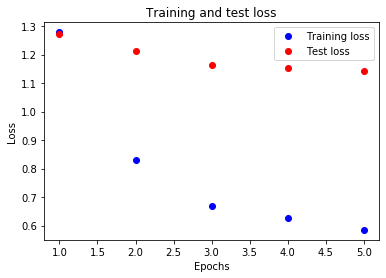

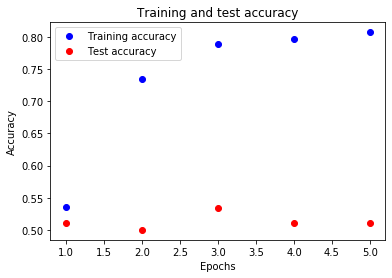

In [17]:
plot_history(history)

Next, we'll create the same network, except this time we'll unfreeze some of the last layers in the NAS Large network. This will allow the network learn features specific to this dataset, although training times will be slowed.

In [0]:
feature_extraction = NASNetLarge(weights='imagenet', include_top=False, input_shape=(input_height, input_width, 3))

model2 = models.Sequential()
model2.add(feature_extraction)
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))

In [19]:
freezeUptoLayer = "normal_add_1_15"

print("\ntrainable layers before unfreezing the base network up to " + freezeUptoLayer + ": ", int(len(model2.trainable_weights) / 2)) 
feature_extraction.trainable = True
set_trainable = False
for layer in feature_extraction.layers:
    if layer.name == freezeUptoLayer: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
print("trainable layers after the base network unfreezed from layer " + freezeUptoLayer + ": ", int(len(model2.trainable_weights)/2))


trainable layers before unfreezing the base network up to normal_add_1_15:  510
trainable layers after the base network unfreezed from layer normal_add_1_15:  71


In [20]:
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

callbacks = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_acc', factor=factor, patience=patience, verbose=1)]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 4032)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1032448   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 85,950,808
Trainable params: 31,197,382
Non-trainable params: 54,753,426
_________________________________________________________________


In [21]:
# training the model
history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch=42000 // (batch_size *  10),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_generator,
    validation_steps=90,
    verbose=True)

Epoch 1/5
65/65 [==============================] - 907s 14s/step - loss: 0.5392 - acc: 0.8101 - val_loss: 1.1748 - val_acc: 0.6889

Epoch 00001: val_acc improved from -inf to 0.68889, saving model to /content/drive/My Drive/CAP 4630 Assignments/weights/weights_temp.h5
Epoch 2/5
65/65 [==============================] - 930s 14s/step - loss: 0.1016 - acc: 0.9671 - val_loss: 0.8228 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.68889 to 0.80000, saving model to /content/drive/My Drive/CAP 4630 Assignments/weights/weights_temp.h5
Epoch 3/5
65/65 [==============================] - 870s 13s/step - loss: 0.0774 - acc: 0.9743 - val_loss: 1.2326 - val_acc: 0.7444

Epoch 00003: val_acc did not improve from 0.80000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/5
65/65 [==============================] - 1064s 16s/step - loss: 0.0463 - acc: 0.9846 - val_loss: 1.0511 - val_acc: 0.7667

Epoch 00004: val_acc did not improve from 0.80000

Epoch 00004:

In [0]:
model2.load_weights(weights_path)
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])
model2.save(os.path.join(models_path, 'finetuned.h5'))

As we can see, unfreezing layers in the feature extraction network significantly boosted performance. We are now able to achieve an 80% accuracy on the test set. The model also does not overfit quite as hard. It should be noted that we only trained for 5 epochs, and took a small amount of update steps in each epoch. This had to be done due to the constraints of collab. Had we increased these parameters it is expected that the network would have performed much better.

In [23]:
test_loss, test_acc = model2.evaluate_generator(test_generator)

print('Test accuracy:', test_acc)

Test accuracy: 0.8


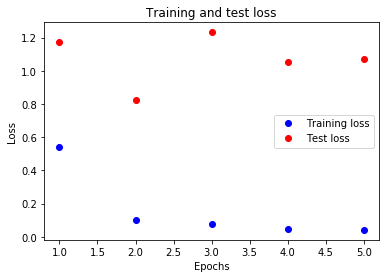

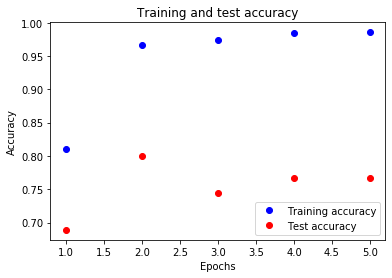

In [24]:
plot_history(history2)

We can now test our trained model on a few images from the test set.

In [11]:
trained_model = load_model(os.path.join(models_path, 'finetuned.h5'))

In [0]:
def test_model(model, num_images):
    images_so_far = 0
    fig = plt.figure(num_images, (20,20))

    for i, (image, labels) in enumerate(test_generator):
        # Get ground truth
        actual = class_labels[np.argmax(labels)]

        # Predict on image and get label from classes array
        output = trained_model.predict(image)
        pred = class_labels[np.argmax(output)]

        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('Actual: {} \n Prediction: {}'.format(actual, pred))
        
        plt.imshow(image[0])
        if images_so_far == num_images:
            return

Looks like the model is doing quite well!

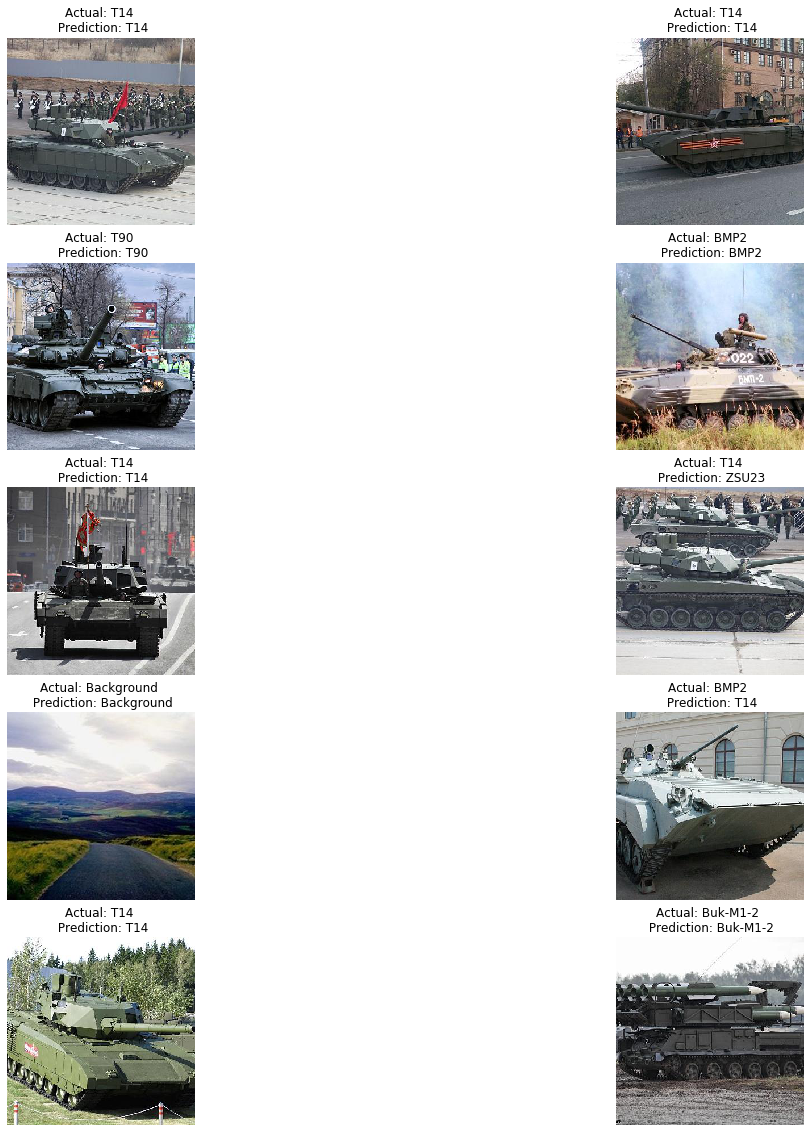

In [44]:
test_model(trained_model, 10)